<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization 

$$
\begin{align} 
\min_{x, z, w} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R} \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w \leq M z_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) \leq  y_i^{\intercal} w \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [215]:
from google.colab import drive 
drive.mount('/content/gdrive')
import gurobipy as gp
from gurobipy import GRB
from math import sqrt
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')

from packages import *

%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')

Mounted at /content/gdrive


In [226]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB

e = gp.Env(empty=True)
gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
e.start()


Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


<gurobipy.Env, No parameter changes>

In [225]:
gurobi_licence.columns

Index(['WLSACCESSID', ' LICENSEID', ' WLSSECRET'], dtype='object')

In [20]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [42]:
#preprocessing 
cov_, mean_ = forecasts[mth]
N = 40
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"GRW8"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
Y_['bias'] = 1
ret_constr = -1

valid tickers: Index(['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK',
       'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME',
       'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO',
       'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX',
       'BWA'],
      dtype='object')


In [202]:
class SVMMVO:

  bigM = 100

  def __init__(self, tics, mean_ret, cov, ret_constr, exogenous, svm_constr = False):
    self.tics = tics #list of tickers
    self.mean_ret = mean_ret
    self.cov = cov
    self.ret_constr = ret_constr
    self.exogenous = exogenous
    self.svm_constr = svm_constr

    N, m = self.exogenous.shape
    self.model = gp.Model()
    self.x = self.model.addMVar(N)
    self.w = self.model.addMVar(m)
    self.z = self.model.addMVar(N, vtype=GRB.BINARY)
  
    self.ret_target = self.model.addConstr(mean_ret[:,0] @ self.x >= self.ret_constr, 'target')
    self.port_exptd_ret = mean_ret[:,0] @ self.x
    self.portfolio_risk = self.x @ self.cov @ self.x

  def setModel(self):
    N, m = self.exogenous.shape
    
    svm_margin = (1/2)*(self.w @ self.w)
    self.model.addConstr(self.x.sum() == 1, 'budget')

    if self.svm_constr:
      self.model.setObjective(self.portfolio_risk + svm_margin, GRB.MINIMIZE) # if z is zero then x must be zero
      self.model.addConstr(x <= z, "z force x" ) #if x is close to zero then z must be zero 
      self.model.addConstr(z <= 100*bigM*x, "z force x" ) # if z is zero then x must be zero
      for i in range(N): #adding the SVM type constraints
        y_i = self.exogenous.iloc[i].values
        self.model.addConstr(self.w @ y_i <= -0.001 +  (bigM)*self.z[i], "svm1" ) 
        self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + 0.001 <= y_i @ self.w , "svm2" )
    else:#not svm mvo
      self.model.setObjective(self.portfolio_risk, GRB.MINIMIZE)
      self.model.remove([self.w, self.z])

  def optimize(self):
    self.model.optimize()
    self.model.write('portfolio_selection_optimization.lp')

  def evaluate(self, realized_ret):
    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers

  def get_results(self, export_dir = '', fig_size = ()):
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    results = pd.DataFrame(data=np.append(self.x.X, [vol_metric, expt_ret_metric]),
    index= list(self.tics) + ['Volatility', 'Expected Return'], columns=['Minimum Risk Portfolio'])
    if (export_dir != ''):
      results.to_csv(export_dir+'results.csv')
    if fig_size != () and type(fig_size) in [list, tuple]:
      results.plot(figsize = fig_size)
    return  results 

  def get_frontier(self, export_dir = '', fig_size = (10,8)):
    mean_ret = self.mean_ret[:,0]
    frontier = np.empty((2,0))
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    print(expt_ret_metric)

    self.model.remove(self.ret_target)
    self.model.update()

    self.ret_target = self.model.addConstr(self.port_exptd_ret == expt_ret_metric, 'target ==')
    self.model.update()

    for r in np.linspace(mean_ret.min(), mean_ret.max(), 25):
      self.ret_target[0].rhs = r
      self.model.optimize()
      vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
      frontier = np.append(frontier, [[vol_metric],[r]], axis=1)

    #restore model to original state
    self.model.remove(self.ret_target)
    self.model.update()
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    self.model.optimize()

    fig, ax = plt.subplots(figsize=fig_size)
    # Plot volatility versus expected return for individual stocks
    # ax.scatter(x=std, y=delta,
    #           color='Blue', label='Individual Stocks')
    # for i, stock in enumerate(stocks):
    #     ax.annotate(stock, (std[i], delta[i]))

    # Plot volatility versus expected return for minimum risk portfolio
    # ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
    # ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
    #             horizontalalignment='right')

    # Plot efficient frontier
    ax.plot(frontier[0], frontier[1], '-*', label='Efficient Frontier', color='DarkGreen')

    # Format and display the final plot
    ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, mean_ret.min()*1.2, mean_ret.max()*1.2])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    # ax.legend()
    ax.grid()
    plt.show()
    if (export_dir != ''):
      plt.savefig(export_dir+"EfficientFrontier.png")
    return frontier 


### Simple Min Variance Portfolio 

In [203]:
MVO = SVMMVO(tics, mean, cov, ret_constr, Y_, svm_constr = False) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 2 rows, 40 columns and 80 nonzeros
Model fingerprint: 0x59fa5cf3
Model has 820 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 40 columns, 80 nonzeros
Presolved model has 820 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 39
 AA' NZ     : 8.200e+02
 Factor NZ  : 8.610e+02
 Factor Ops : 2.382e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.02804868e+05 -2.02804868e+05  3.62e+04 2.40e-05  1.00e+06     0s
   1   9.96605306e+04 -1.00162207e+05  2.52e+03 1

,Minimum Risk Portfolio
AAPL,1.970215e-10
ABC,2.813541e-10
ABMD,3.668019e-09
ABT,9.019475e-02
ADBE,3.102378e-10
ADI,4.422678e-08
ADM,8.827629e-02
ADP,2.420754e-02
ADSK,3.943062e-10
AEE,2.105399e-01


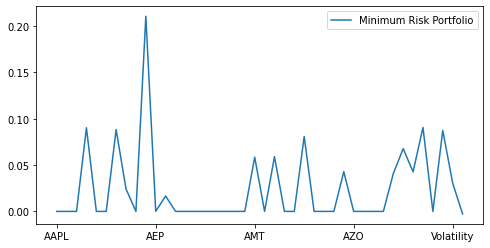

In [204]:
MVO.get_results(fig_size=(8,4))

-0.0027149847498092712


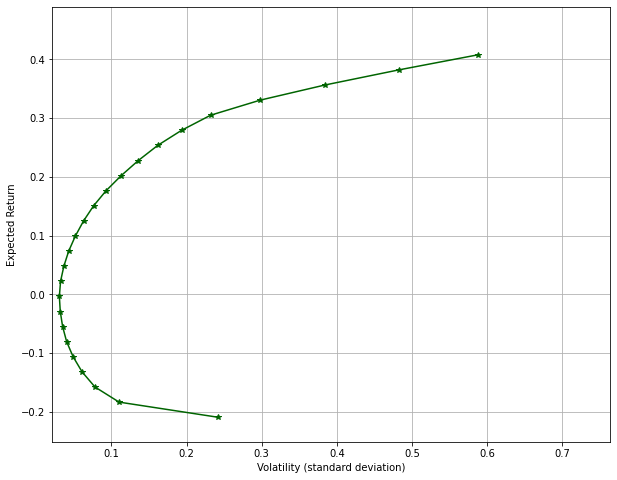

In [210]:
MVO.model.setParam('OutputFlag', 0)
MVO_frontier = MVO.get_frontier()

### Mean Variance and SVM Joint Formulation

In [211]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, Y_, svm_constr = True)
SVM_MVO.setModel()
SVM_MVO.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 162 rows, 118 columns and 3360 nonzeros
Model fingerprint: 0x0ca6b3c9
Model has 858 quadratic objective terms
Variable types: 78 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]
Found heuristic solution: objective 2.9157460
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 161 rows, 118 columns, 3320 nonzeros
Presolved model has 858 quadratic objective terms
Variable types: 78 continuous, 40 integer (40 binary)

Root relaxation: objective 9.392317e-04, 96 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

,Minimum Risk Portfolio
AAPL,0.000100
ABC,0.000100
ABMD,0.000100
ABT,0.090534
ADBE,0.000100
ADI,0.000100
ADM,0.088181
ADP,0.024103
ADSK,0.000100
AEE,0.209858


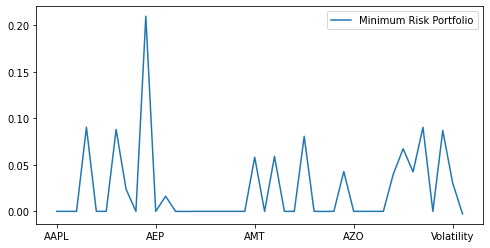

In [208]:
SVM_MVO.get_results(fig_size=(8,4))

In [212]:
SVM_MVO.get_frontier()

-0.002651385784305171
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 162 rows, 118 columns and 3360 nonzeros
Model fingerprint: 0xea72b9ff
Model has 858 quadratic objective terms
Variable types: 78 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 22 rows and 22 columns
Presolve time: 0.01s
Presolved: 140 rows, 96 columns, 3272 nonzeros
Presolved model has 473 quadratic objective terms
Variable types: 67 continuous, 29 integer (29 binary)

Root relaxation: objective 5.828965e-02, 113 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

GurobiError: ignored